In [1]:
import os
import csv
import urllib.request as req

import numpy as np
import pandas as pd
import xarray as xr

import bokeh as bo
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_1d_csv(get_req, this, total):

    _date, _init_hour, _url = get_req
    
    try:
        response = req.urlopen(_url).read().decode('utf-8')
        print('\r[%d/%d] %s %s'%(this, total, _date, _init_hour), end='')
        
    except:
        print('\r[%d/%d] NOT FOUND %s %s'%(this, total, _date, _init_hour), end='')
        return None
    
    else:
        init = datetime(_date.year, _date.month, _date.day, _init_hour, 0)

        response = response.split('\n')
        header = np.append('InitTime', response[0].split(','))
        
        lines = []
        for line in response[1:]:
            line = line.split(',')

            try:
                line[0] = datetime.strptime(line[0], '%Y%m%d%H')
            except:
                pass
            else:
                lines.append(np.append(init, line))
                        
        return header, lines

In [111]:
def get_precip_obs(s, d0, d1):
    import requests

    # Tokens registered to michael.wessler@noaa.gov
    api_token = 'a2386b75ecbc4c2784db1270695dde73'
    api_key = 'Kyyki2tc1ETHUgShiscycW15e1XI02SzRXTYG28Dpg'
    base = 'https://api.synopticdata.com/v2/stations/precip?'
    
    allints = []
    
    forecast_interval = 6
    for interval in [6, 12, 24]:
        
        # Limit how big the observation lag can be (minutes)
        lag_limit = (interval/2)*60
        repeat = int((interval-forecast_interval)/6)+1
        
        df = []
        while repeat > 0:
            print('Working: Interval {}h Iteration {}'.format(interval, repeat))
                        
            _d0 = d0+timedelta(hours=(forecast_interval)*(repeat-1))
            _d1 = d1+timedelta(hours=1+forecast_interval*(repeat-1))
            
            url = base + 'stid={}&start={}&end={}&pmode=intervals&interval={}&token={}'.format(
                s,
                datetime.strftime(_d0, '%Y%m%d%H%M'),
                datetime.strftime(_d1, '%Y%m%d%H%M'),
                interval, api_token)
            
            api_data_raw = requests.get(url).json()

            vdates = pd.date_range(_d0, _d1, freq='%dh'%interval)
            
            for i in api_data_raw['STATION'][0]['OBSERVATIONS']['precipitation']:
                
                if i['last_report'] is not None:
                    
                    last_rep = datetime.strptime(i['last_report'], '%Y-%m-%dT%H:%M:%SZ')
                    vtime = vdates[np.argmin(np.abs(vdates - last_rep))]
                    lag_mins = (vtime - last_rep).seconds/60
                    value = float(i['total']) if lag_mins < lag_limit else np.nan
                    
                    #print('{}\t{}\t{}\t{}'.format(vtime, last_rep, lag_mins, value))
                    df.append([vtime, last_rep, lag_mins, value])
                    
            repeat -= 1

        allints.append(pd.DataFrame(df, 
            columns=['ValidTime', 'last_report', '%sh_lag_mins'%interval, '%sh_precip_mm'%interval]
            ).set_index('ValidTime').sort_index())

    return allints

In [142]:
# NBM 1D Viewer Site to use
site = 'KBUF'
vsite = 'KBUF' #expand to list of sties later on?
init_hours = [1, 7, 13, 19] #[4, 16]

os.makedirs('./%s/'%site, exist_ok=True)

# Data Range
date0 = datetime(2020, 5, 15)
date1 = datetime(2020, 5, 30)
dates = pd.date_range(date0, date1, freq='1D')

lead = 263 #10d @ 240h
date2 = date1 + timedelta(hours=lead)

In [143]:
obs = get_precip_obs(vsite, date0, date2)
obs = obs[0].merge(obs[1], how='inner', on='ValidTime').merge(obs[2], how='inner', on='ValidTime')
obs = obs[[k for k in obs.keys() if 'precip' in k]].sort_index()

Working: Interval 6h Iteration 1
Working: Interval 12h Iteration 2
Working: Interval 12h Iteration 1
Working: Interval 24h Iteration 4
Working: Interval 24h Iteration 3
Working: Interval 24h Iteration 2
Working: Interval 24h Iteration 1


In [144]:
url_list = []
for date in dates:
    for init_hour in init_hours:
        # For now pull from the csv generator
        # Best to get API access or store locally later
        base = 'https://hwp-viz.gsd.esrl.noaa.gov/wave1d/data/archive/'
        datestr = '{:04d}/{:02d}/{:02d}'.format(date.year, date.month, date.day)
        sitestr = '/NBM/{:02d}/{:s}.csv'.format(init_hour, site)
        url_list.append([date, init_hour, base + datestr + sitestr])

# Try multiprocessing this for speed?
nbm = np.array([get_1d_csv(url, this=i+1, total=len(url_list)) for i, url in enumerate(url_list)])
nbm = np.array([line for line in nbm if line is not None])

header = nbm[0, 0]
nbm = np.array([line[1] for line in nbm])

nbm = nbm.reshape(-1, nbm.shape[-1])
nbm[np.where(nbm == '')] = np.nan

# Aggregate to a clean dataframe
nbm = pd.DataFrame(nbm, columns=header).set_index(
    ['InitTime', 'ValidTime']).sort_index()

# Drop last column (misc metadata?)
nbm = nbm.iloc[:, :-2].astype(float)
header = nbm.columns

# variables = np.unique([k.split('_')[0] for k in header])
# levels = np.unique([k.split('_')[1] for k in header])

init =  nbm.index.get_level_values(0)
valid = nbm.index.get_level_values(1)

# Note the 1h 'fudge factor' in the lead time here
lead = pd.DataFrame(
    np.transpose([init, valid, ((valid - init).values/3600/1e9).astype(int)+1]), 
    columns=['InitTime', 'ValidTime', 'LeadTime']).set_index(['InitTime', 'ValidTime'])

nbm.insert(0, 'LeadTime', lead)

klist = np.array([k for k in np.unique([k for k in list(nbm.keys())]) if ('APCP' in k)&('1hr' not in k)])
klist = klist[np.argsort(klist)]
klist = np.append('LeadTime', klist)
nbm = nbm.loc[:, klist]

[64/64] 2020-05-30 00:00:00 19

In [145]:
lead12 = nbm[nbm['LeadTime'] == 12].reset_index().drop(columns='InitTime').set_index('ValidTime')
pd.DataFrame(lead12['APCP12hr_surface'])

,APCP12hr_surface
ValidTime,
2020-05-15 12:00:00,10.393
2020-05-15 18:00:00,7.467
2020-05-16 00:00:00,14.437
2020-05-16 06:00:00,8.363
2020-05-16 12:00:00,0.000
...,...
2020-05-30 06:00:00,6.010
2020-05-30 12:00:00,0.056
2020-05-30 18:00:00,0.139


In [146]:
test = pd.DataFrame(lead12['APCP6hr_surface_90% level']).merge(obs['6h_precip_mm'], on='ValidTime')
test

,APCP6hr_surface_90% level,6h_precip_mm
ValidTime,,
2020-05-16 00:00:00,18.098,3.048
2020-05-16 06:00:00,0.500,0.000
2020-05-16 12:00:00,0.000,0.000
2020-05-16 18:00:00,0.000,0.000
2020-05-17 00:00:00,0.000,0.000
...,...,...
2020-05-30 06:00:00,3.701,0.000
2020-05-30 12:00:00,0.000,0.000
2020-05-30 18:00:00,1.214,0.025


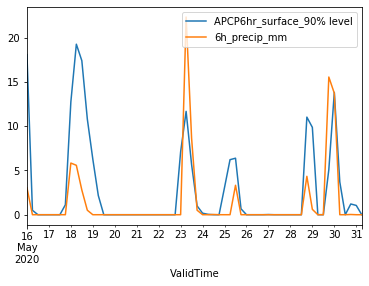

In [147]:
test.plot()